In [3]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# project specific libs
import os
import matplotlib.pyplot as plt

In [4]:
# set project path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/'

In [5]:
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)

# get first row for any future operations
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map = df_map.iloc[1:,]

# remove separate and together columns
df_map = df_map.drop(['Separate','Together'], axis=1)

# subset on useful columns
# TwinPair and Diagnosis are useful columns
df_map = df_map.loc[:,['TwinPair','Diagnosis']]

df_map.head()

,TwinPair,Diagnosis
#SampleID,,
500A.Fecal,T2,RA
501A.Fecal,T2,Unaffected
502A.Fecal,T3,RA
503A.Fecal,T3,Unaffected
504A.Fecal,T4,RA


In [73]:
# loop over L3, L6 and L7
# look at Clostridia and Bacteroidia 
Lx_to_df = {}
Lx_to_str = {
    'L3': 'level-3_10k',
    'L6': 'level-6_10k',
    'L7': 'level-7_10k'
}

for l in Lx_to_str:
    df_otu = pd.read_csv(path + 'inputs/Qiime2_0_KB/' + Lx_to_str[l] + '.csv',index_col=0)
    
    df_diag = df_otu['Diagnosis']
    otu_cols = []

    for c in list(df_otu.columns.values):
        if '__' in c:
            otu_cols.append(c)

    # subset on OTU
    df_otu = df_otu.loc[:,otu_cols]

    # divide by row sum (i.e. sample count) to normalize
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    
    # save to dict
    Lx_to_df[l] = df_otu

df_otu.head()

,Unassigned;__;__;__;__;__;__,k__Archaea;__;__;__;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;__;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__;__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__;s__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea;s__devanaterra,k__Archaea;p__Euryarchaeota;c__DSEG;o__ArcA07;f__;g__;s__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;__,...,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__Ellin517;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__R4-41B;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__auto67_4W;g__;s__,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__;s__,k__Bacteria;p__WPS-2;c__;o__;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;__;__;__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__;s__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__;s__,k__Bacteria;p__ZB3;__;__;__;__;__,k__Bacteria;p__ZB3;c__BS119;o__;f__;g__;s__
index,,,,,,,,,,,,,,,,,,,,,
182A.Fecal,0.0,0.00000,0.000148,0.0,0.0,0.00000,0.001531,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000605,0.0,0.000594,0.0,0.0,0.0,0.000000
183A.Fecal,0.0,0.00012,0.000167,0.0,0.0,0.00047,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000375,0.0,0.000120,0.0,0.0,0.0,0.000000
500A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002825,0.0,0.000000,0.0,0.0,0.0,0.000000
501A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.001800,0.0,0.0,0.0,0.000000
502A.Fecal,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.002229


In [17]:
# paired shannon diversity difference from 0 
df_alpha = pd.read_csv(path + 'inputs/Qiime2_0_KB/shannon_metadata_10k.tsv', sep='\t', index_col=0)

# drop unnecessary rows and cols
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha.drop('Separate', axis=1)
df_alpha = df_alpha.drop(['Elutionbuffer1','Elutionbuffer2','blank'])

# get paired per twin pair
pair_to_diff = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    alpha_UA = float(df[df['Diagnosis'] == 'Unaffected']['shannon_entropy'].values)
    alpha_RA = float(df[df['Diagnosis'] == 'RA']['shannon_entropy'].values)
    pair_to_diff[p] = alpha_RA - alpha_UA

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['Shannon_Diff'])
df_paired_alpha

,Shannon_Diff
T1,-0.407445
T2,-0.273755
T3,0.331704
T4,0.048646
T5,1.907472
T6,-1.829056
T7,1.535143
T8,-0.327622
T9,1.788720
T10,-0.205716


0.6923233992730163 0.5062023293175164


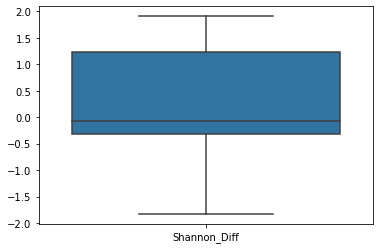

In [18]:
# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha['Shannon_Diff'],popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=df_paired_alpha)

In [20]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'inputs/Qiime2_0_KB/core_metrics_10k/unweighted_unifrac_distance_matrix.tsv', sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Dist'])
df_paired_beta


,Unweighted_Dist
T1,0.700096
T2,0.698035
T3,0.779151
T4,0.779873
T5,0.866523
T6,0.816092
T7,0.646555
T8,0.648694
T9,0.736053
T10,0.676790


-10.207956903186044 4.604717992358901e-13


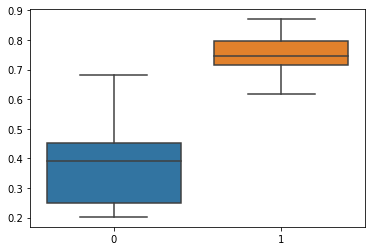

In [44]:
# grab inter RA distances
df_raw = pd.read_csv(path + 'inputs/Qiime2_0_KB/unweighted_raw_data.tsv', sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']

# compare distances
inter_twin = df_paired_beta['Unweighted_Dist'].values
inter_RA = df_RA['Distance'].values

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
print(t, p)

sns.boxplot([inter_twin, inter_RA])

In [22]:
# correlate class clostridia and bacteroidia
df_otu_L3J = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/3_taxa.summary_qiime/all_by.sample/otu_table_RA.twins_16S_all_L3.txt', sep='\t', skiprows=1)
df_otu_L3J = df_otu_L3J.set_index('#OTU ID')
df_otu_L3J = df_otu_L3J.T
df_otu_L3J = df_otu_L3J.drop(['182A.Fecal','183A.Fecal','Elutionbuffer1','Elutionbuffer2'])#
df_otu_L3J.head()

#OTU ID,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota,k__Archaea;p__Euryarchaeota;c__Halobacteria,k__Archaea;p__Euryarchaeota;c__Methanobacteria,k__Archaea;p__Euryarchaeota;c__Thermoplasmata,k__Bacteria;p__Acidobacteria;c__Acidobacteria-6,k__Bacteria;p__Acidobacteria;c__Acidobacteriia,k__Bacteria;p__Acidobacteria;c__Holophagae,k__Bacteria;p__Acidobacteria;c__[Chloracidobacteria],k__Bacteria;p__Actinobacteria;c__Acidimicrobiia,k__Bacteria;p__Actinobacteria;c__Actinobacteria,...,k__Bacteria;p__Tenericutes;c__Mollicutes,k__Bacteria;p__Tenericutes;c__RF3,k__Bacteria;p__Verrucomicrobia;c__Opitutae,k__Bacteria;p__Verrucomicrobia;c__Verruco-5,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae],k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria],k__Bacteria;p__WPS-2;c__,k__Bacteria;p__WS3;c__PRR-12,k__Bacteria;p__[Thermi];c__Deinococci
500A.Fecal,0.0,0.0,0.000098,0.000000,0.0,0.0,0.0,0.0,0.0,0.003838,...,0.000000,0.0,0.0,0.0,0.000049,0.0,0.0,0.0,0.0,0.0
501A.Fecal,0.0,0.0,0.000597,0.001247,0.0,0.0,0.0,0.0,0.0,0.001898,...,0.000000,0.0,0.0,0.0,0.011497,0.0,0.0,0.0,0.0,0.0
502A.Fecal,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000149,...,0.000000,0.0,0.0,0.0,0.000025,0.0,0.0,0.0,0.0,0.0
503A.Fecal,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000029,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
504A.Fecal,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.020568,...,0.000048,0.0,0.0,0.0,0.031101,0.0,0.0,0.0,0.0,0.0


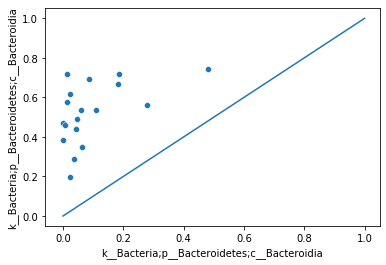

In [23]:
# Bacteroidia; x is KB, y is JW
plt.figure()
sns.scatterplot(x=Lx_to_df['L3']['k__Bacteria;p__Bacteroidetes;c__Bacteroidia'], y=df_otu_L3J['k__Bacteria;p__Bacteroidetes;c__Bacteroidia'])
plt.plot([0, 1], [0, 1])
#plt.close()

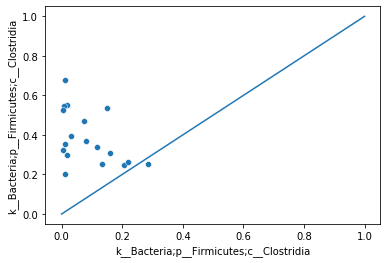

In [24]:
# Clostridia; x is KB, y is JW
plt.figure()
sns.scatterplot(x=Lx_to_df['L3']['k__Bacteria;p__Firmicutes;c__Clostridia'], y=df_otu_L3J['k__Bacteria;p__Firmicutes;c__Clostridia'])
plt.plot([0, 1], [0, 1])
#plt.close()

In [27]:
# plotting differential relative taxa

# create dict mapping disease to samples
diag_to_samp = {}

# 'RA', 'Unaffected'
for d in list(df_alpha.Diagnosis.values):
    diag_to_samp[d] = list(df_alpha[df_alpha['Diagnosis'] == d].index.values)

# pair_to_ids gives UA, RA pairings
pair_to_ids

{'T1': ('183A.Fecal', '182A.Fecal'),
 'T2': ('501A.Fecal', '500A.Fecal'),
 'T3': ('503A.Fecal', '502A.Fecal'),
 'T4': ('505A.Fecal', '504A.Fecal'),
 'T5': ('507A.Fecal', '506A.Fecal'),
 'T6': ('509A.Fecal', '508A.Fecal'),
 'T7': ('511A.Fecal', '510A.Fecal'),
 'T8': ('513A.Fecal', '512A.Fecal'),
 'T9': ('515A.Fecal', '514A.Fecal'),
 'T10': ('517A.Fecal', '516A.Fecal')}

In [43]:
# determine paired differences and test significance from 0 
# get differences and p values
Lx_to_diffs ={
    'L3': {},#defaultdict(),
    'L6': {},
    'L7': {}
}
for l in Lx_to_df:
    print(l)
    for u in list(Lx_to_df[l].columns.values):
        diffs = []
        for v in pair_to_ids:
            id_UA, id_RA = pair_to_ids[v]
            diffs.append(Lx_to_df[l].loc[id_RA, u] - Lx_to_df[l].loc[id_UA, u])
        # one-sided t-test, n.s.; RA-UA values 
        t, p =  scipy.stats.ttest_1samp(diffs, popmean=0)
        if p < 0.05:
            print(u)
            print(t, p)
        Lx_to_diffs[l][u] = diffs


L3
k__Bacteria;p__TM7;c__TM7-3
-2.6487035448625176 0.026532521261768527
L6
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces
-3.3989598248560453 0.00788631438493314
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Rickettsiaceae;g__
2.7414523330904466 0.02279334469289356
k__Bacteria;p__TM7;c__TM7-3;o__;f__;g__
-2.344199561315291 0.04371851778399067
L7
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__
-3.3989598248560453 0.00788631438493314
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Rickettsiaceae;g__;s__
2.7414523330904466 0.02279334469289356
k__Bacteria;p__TM7;c__TM7-3;o__;f__;g__;s__
-2.344199561315291 0.04371851778399067


-3.3989598248560453 0.00788631438493314


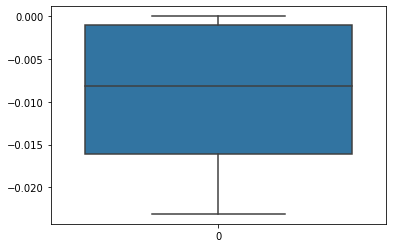

In [39]:
# k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces
# enrichment in RA twins vs UA twins within pairs

# values
diffs = Lx_to_diffs['L6']['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces']

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)


2.7414523330904466 0.02279334469289356


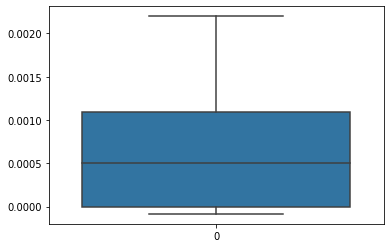

In [40]:
# enrichment in UA twins vs RA twins within pairs
x = 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Rickettsiaceae;g__'

# values
diffs = Lx_to_diffs['L6'][x]

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)


-0.406619050626261 0.6937873049064738


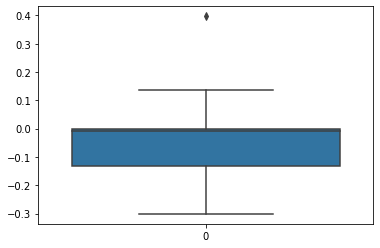

In [45]:
# where is our prevotella friend
x = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella'#;s__copri'

# values
diffs = Lx_to_diffs['L6'][x]

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)


1.247197933633023 0.24380258802980137


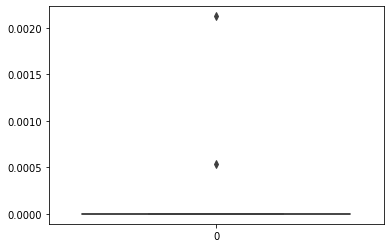

In [46]:
# where is our prevotella friend
x = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'

# values
diffs = Lx_to_diffs['L7'][x]

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)


-2.6487035448625176 0.026532521261768527


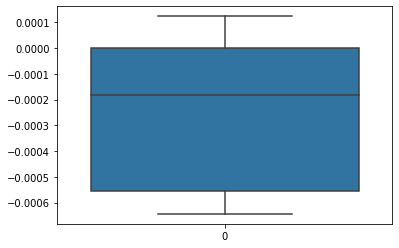

In [47]:
# only L3 trend
x='k__Bacteria;p__TM7;c__TM7-3'

# values
diffs = Lx_to_diffs['L3'][x]

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)



0.7366332615874394 0.4801054591334918


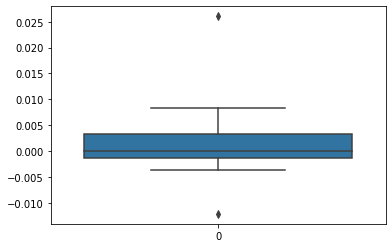

In [50]:
x='k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium'

# values
diffs = Lx_to_diffs['L6'][x]

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(diffs,popmean=0)
print(t, p)

# boxplot
sns.boxplot(data=diffs)



0.560544363404882 0.5820188998695353


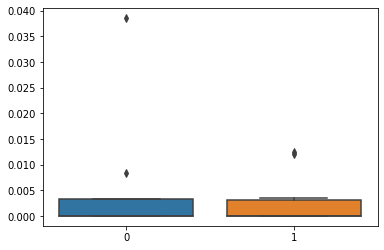

In [66]:
# grab inter RA distances
df_raw = Lx_to_df['L6']

x='k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium'
a = df_raw.loc[diag_to_samp['RA'], x]
b = df_raw.loc[diag_to_samp['Unaffected'], x]

t, p = scipy.stats.ttest_ind(a, b)
print(t, p)

sns.boxplot([a, b])

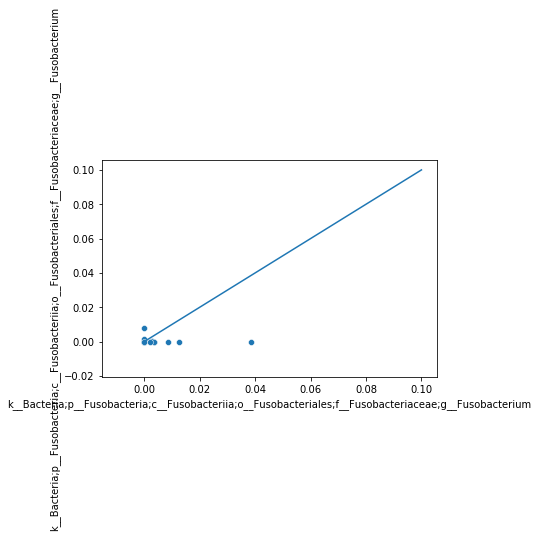

In [69]:
x = 'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium'
df_otu_L6J = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/3_taxa.summary_qiime/all_by.sample/otu_table_RA.twins_16S_all_L6.txt', sep='\t', skiprows=1)
df_otu_L6J = df_otu_L6J.set_index('#OTU ID')
df_otu_L6J = df_otu_L6J.T
df_otu_L6J = df_otu_L6J.drop(['182A.Fecal','183A.Fecal','Elutionbuffer1','Elutionbuffer2'])#

plt.figure()
sns.scatterplot(x=Lx_to_df['L6'][x], y=df_otu_L6J[x])
plt.plot([0, 0.1], [0, 0.1])
#plt.close()

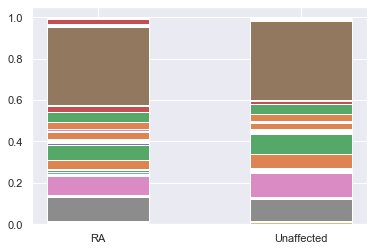

In [95]:
# stacked barplot

# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# load dataset
# tips = sns.load_dataset("tips")
df = Lx_to_df['L3']

df['Diagnosis'] = df_diag
df = df[df['Diagnosis'] != 'control']

otu_cols = list(Lx_to_df['L3'].columns.values)
otu_cols.remove('Diagnosis')


width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for t in otu_cols:
    RA_abund = np.mean(Lx_to_df['L3'].loc[diag_to_samp['RA'],t])
    UA_abund = np.mean(Lx_to_df['L3'].loc[diag_to_samp['Unaffected'],t])
    
    weight_count = np.array([RA_abund,UA_abund])
    p = ax.bar(['RA','Unaffected'], weight_count, width, label=t, bottom=bottom)
    bottom += weight_count

#ax.set_title("Number of penguins with above average body mass")
#ax.legend(loc="upper right")

plt.show()

